In [3]:
import requests as rq
import pandas as pd
from datetime import datetime, timedelta
from sklearn import preprocessing
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression as LR 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import MultipleLocator
import os
import warnings
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor as KNN
from xgboost import XGBRegressor as XGB
from sklearn.datasets import dump_svmlight_file

warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'requests'

# Get the electricity demand data

In [2]:
end = '20190918T23-05'
start = '20130918T23-05'
key = '8a6315646d5695061696c71a041c42c0'
series_id = 'EBA.TEX-ALL.D.HL'
data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, start, end))

In [3]:
hourly_demand = data.json()['series'][0]['data']

In [4]:
electricity_demand = pd.DataFrame(hourly_demand, columns=['datetime','usage'])
# electricity_demand.to_csv('electricity_data/electricity_demand.csv')

In [5]:
# electricity_demand = pd.read_csv('electricity_data/electricity_demand.csv')
electricity_demand['datetime'] = pd.to_datetime(electricity_demand['datetime'], format='%Y%m%dT%H-%M')
electricity_demand['time'] = electricity_demand['datetime'].apply(lambda x:x.hour)
electricity_demand['month'] = electricity_demand['datetime'].apply(lambda x:x.month)
electricity_demand['weekday'] = electricity_demand['datetime'].apply(lambda x:x.weekday())
electricity_demand['year'] = electricity_demand['datetime'].apply(lambda x:x.year)
electricity_demand['day'] = electricity_demand['datetime'].apply(lambda x:x.day)

In [6]:
# Normalize the usage
electricity_demand['normalized_usage'] = preprocessing.MinMaxScaler().fit_transform(electricity_demand['usage'].values.reshape(-1,1))
electricity_demand.head(3)

,datetime,usage,time,month,weekday,year,day,normalized_usage
0,2019-09-18 23:05:00,51199,23,9,2,2019,18,0.531163
1,2019-09-18 22:05:00,55171,22,9,2,2019,18,0.610970
2,2019-09-18 21:05:00,58070,21,9,2,2019,18,0.669218


In [2]:
electricity_demand.tail(20)

NameError: name 'electricity_demand' is not defined

# Get the hourly weather data

In [8]:
'''
# Other weather data.
temp_dir = 'electricity_data/temperatures/'
# temp_dir = 'electricity_data/NW/'

# stations = []
# weather = pd.DataFrame()

for file in os.listdir(temp_dir):
    if file.endswith('.csv'):
        temp_df = pd.read_csv(temp_dir+file)
        stations.append(temp_df.head(1)['STATION'].values[0])
        weather = pd.concat([weather, temp_df], axis=0)
'''

weather_2013 = pd.read_csv('electricity_data/hourly_temperature_2013.csv')
weather_2015 = pd.read_csv('electricity_data/hourly_temperature_2015.csv')
weather_2016 = pd.read_csv('electricity_data/hourly_temperature_2016.csv')
weather = pd.concat([weather_2013, weather_2015, weather_2016])
stations = [72243012960, 72259003927, 72253012921]

In [9]:
weather.head(1)

,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,...,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurationPrecipitationValue150,ShortDurationPrecipitationValue180,Sunrise,Sunset,TStorms,WindEquipmentChangeDate
0,72243012960,2013-09-18T00:00:00,FM-12,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-06-11


In [10]:
# Many columns has very few useful rows. Collect only useful columns.
columns = weather.columns
num = len(weather)
num

281350

In [11]:
useful_columns = []
for column in columns:
    if sum(weather[column].isna()) > 30000:
        # There are more than 10000 nan
        print('{} is abondoned, containing {} NaN'.format(column, sum(weather[column].isna())))
    else:
        useful_columns.append(column)

AWND is abondoned, containing 281101 NaN
BackupDirection is abondoned, containing 281350 NaN
BackupDistance is abondoned, containing 281350 NaN
BackupDistanceUnit is abondoned, containing 281350 NaN
BackupElements is abondoned, containing 281350 NaN
BackupElevation is abondoned, containing 281350 NaN
BackupElevationUnit is abondoned, containing 281350 NaN
BackupEquipment is abondoned, containing 281350 NaN
BackupLatitude is abondoned, containing 281350 NaN
BackupLongitude is abondoned, containing 281350 NaN
BackupName is abondoned, containing 281350 NaN
CDSD is abondoned, containing 281101 NaN
CLDD is abondoned, containing 281101 NaN
DSNW is abondoned, containing 281101 NaN
DailyAverageDewPointTemperature is abondoned, containing 274149 NaN
DailyAverageDryBulbTemperature is abondoned, containing 273718 NaN
DailyAverageRelativeHumidity is abondoned, containing 274149 NaN
DailyAverageSeaLevelPressure is abondoned, containing 274163 NaN
DailyAverageStationPressure is abondoned, containing

In [12]:
weather = weather[useful_columns]

In [13]:
def round_time(date_time):
    minute = date_time.minute
    if minute > 30:
        return date_time+timedelta(hours=1)
    else:
        return date_time

In [14]:
def parse_temperature(s):
    try:
        return float(s)
    except:
        try:
            return float(re.split('[a-z]+', s)[0])
        except:
            return np.nan

In [15]:
# Round the date info
weather['datetime'] = pd.to_datetime(weather['DATE'], format='%Y-%m-%dT%H:%M:%S')
weather['date'] = weather['datetime'].apply(lambda date_time: round_time(date_time))
weather['time'] = weather['date'].apply(lambda x:x.hour)
weather['month'] = weather['date'].apply(lambda x:x.month)
weather['day'] = weather['date'].apply(lambda x:x.day)
# weather['weekday'] = weather['date'].apply(lambda x:x.weekday())
weather['year'] = weather['date'].apply(lambda x:x.year)
weather['HourlyDryBulbTemperature'] = weather['HourlyDryBulbTemperature'].apply(lambda s:parse_temperature(s))

In [16]:
# Get rid of nan and duplicated values
match_columns = ['year', 'month', 'day', 'time']
useful_columns = ['STATION', 'DATE', 'HourlyDryBulbTemperature', 'month', 'day', 'time', 'year']
weather = weather.loc[weather['HourlyDryBulbTemperature'].notna(),:]
weather = weather[useful_columns].groupby(match_columns+['STATION'], as_index=False).mean()
weather.head(3)

,year,month,day,time,STATION,HourlyDryBulbTemperature
0,2013,9,18,0,72243012960,77.0
1,2013,9,18,0,72253012921,78.0
2,2013,9,18,0,72259003927,83.0


In [17]:
'''
houston = weather.loc[weather['STATION'] == 72243012960,:]
san_antonio = weather.loc[weather['STATION'] == 72259003927,:]
dallas = weather.loc[weather['STATION'] == 72253012921,:]
'''

"\nhouston = weather.loc[weather['STATION'] == 72243012960,:]\nsan_antonio = weather.loc[weather['STATION'] == 72259003927,:]\ndallas = weather.loc[weather['STATION'] == 72253012921,:]\n"

# Merge the electricity data with the temprature data

In [17]:
'''
df_joined = electricity_demand.merge(houston, how='inner', left_on=match_columns, right_on=match_columns)
df_joined = df_joined.merge(san_antonio, how='inner', left_on=match_columns, right_on=match_columns)
df_joined = df_joined.merge(dallas, how='inner', left_on=match_columns, right_on=match_columns)
'''
bad_station = [72232403071] # Texas
# bad_station = [72063800224] # NW
df_joined = electricity_demand

for station in stations:
    if station not in bad_station:
        df_tmp = weather.loc[weather['STATION'] == station, :]
        if sum(df_tmp['HourlyDryBulbTemperature'].isna()) != 0:
            print(station)
        df_joined = df_joined.merge(df_tmp, how='inner', left_on=match_columns, right_on=match_columns)

In [18]:
'''
new_column_names = ['datetime', 'usage', 'time', 'month', 'weekday', 'year', 'day',
       'normalized_usage', 'STATION_1', 'T_1',
       'STATION_2', 'T_2', 'STATION_3', 'T_3', 'STATION_4', 'T_4',
       'STATION_5', 'T_5', 'STATION_6', 'T_6', 'STATION_7', 'T_7',
       'STATION_8', 'T_8', 'STATION_9', 'T_9', 'STATION_10', 'T_10',
       'STATION_11', 'T_11', 'STATION_12', 'T_12']
'''

new_column_names = ['datetime', 'usage', 'time', 'month', 'weekday', 'year', 'day',
       'normalized_usage', 'STATION_1', 'T_1',
       'STATION_2', 'T_2', 'STATION_3', 'T_3']

df_joined.columns = new_column_names
# df_joined = df_joined.drop(columns=['STATION_x', 'STATION_y', 'STATION']).rename(columns={'HourlyDryBulbTemperature_x':'T_Houston','HourlyDryBulbTemperature_y':'T_san_antonio','HourlyDryBulbTemperature':'T_dallas'})
# df_joined.to_csv('electricity_with_temperature.csv')
df_joined.head(3)

,datetime,usage,time,month,weekday,year,day,normalized_usage,STATION_1,T_1,STATION_2,T_2,STATION_3,T_3
0,2019-09-18 23:05:00,51199,23,9,2,2019,18,0.531163,72243012960,78.0,72259003927,79.0,72253012921,85.0
1,2019-09-18 22:05:00,55171,22,9,2,2019,18,0.610970,72243012960,76.0,72259003927,79.0,72253012921,87.0
2,2019-09-18 21:05:00,58070,21,9,2,2019,18,0.669218,72243012960,78.0,72259003927,81.0,72253012921,89.0


In [19]:
print('Total number of hours: {}'.format(len(df_joined)))
# df_joined = pd.read_csv('electricity_with_temperature.csv',index_col=0)
df_joined = df_joined.sort_values(['datetime']).reset_index(drop=True)

Total number of hours: 36935


In [93]:
# Split the train, validation, test dataset.
valid_index = []
test_index = []
# we want the test and validation set to both cover an entire year. Therefore, they are taking alternative weeks.
for h in np.arange(23175,33096,336):
    valid_index.extend(list(np.arange(h,h+168)))
    test_index.extend(list(np.arange(h+168,h+336)))

# remove indexes larger than 36935
while valid_index[-1] >= 33096:
    valid_index.pop()

while test_index[-1] >= 33096:
    test_index.pop()
    
valid_index = np.asarray(valid_index)
test_index = np.asarray(test_index)

fitting_index=28175
train_index= 23175 #32000
# np.savetxt('valid_index.txt', valid_index)
# np.savetxt('test_index.txt', test_index)

In [94]:
def attenuate(X,Y,beta,column):
    # The first 24 hour will be used as warm up.
    X_new = (1-beta)*X[24:, column:].copy()
    # X_new += 0.9*X[23:-1,column:]+0.9*X[22:-2,column:]+0.9*X[21:-3,column:]+0.9*X[20:-4,column:]# +0.9*X[19:-5,column:]+0.9*X[18:-6,column:]
    # for h in np.arange(1, 6):
        # X_new = np.concatenate((X_new, X[24-h:-1*h,column:]), axis=1)
    for h in np.arange(1, 24):
        X_new += beta**h*(1-beta)*X[24-h:-1*h, column:]
    return np.concatenate((X[24:,:column], X_new), axis=1), Y[24:]

In [95]:
features = ['time', 'weekday', 'month'] + ['T_1','T_2','T_3']
# features = ['time', 'weekday', 'month'] + ['T_1','T_2','T_5','T_12','T_4','T_7','T_6','T_9','T_8','T_3','T_11','T_10']
# features = ['time', 'weekday', 'month', 'T_Houston', 'T_san_antonio', 'T_dallas'] # month may can be abondoned
# features = ['time', 'weekday', 'month'] + ['T_1','T_2','T_3','T_4','T_5','T_6','T_7','T_8','T_9','T_10','T_11','T_12','T_13']
X = df_joined[features].values
Y = df_joined['usage'].values

from sklearn.preprocessing import StandardScaler as SS

# X = SS().fit_transform(X)

def building_temp(beta):
    column = 3

    X_train = X[:train_index]# X[0:15706, :]
    Y_train = Y[:train_index]# Y[0:15706]
    # X_fitting = X[train_index:fitting_index]
    # Y_fitting = Y[train_index:fitting_index]
    X_train, Y_train = attenuate(X_train, Y_train, beta, column)
    # X_fitting, Y_fitting = attenuate(X_fitting, Y_fitting, beta, column)
    X_valid = X[valid_index]# X[15706:20941,:]
    Y_valid = Y[valid_index]# Y[15706:20941]
    # X_test = X[test_index]
    # Y_test = Y[test_index]
    X_valid, Y_valid = attenuate(X_valid, Y_valid, beta, column)
    # X_test, Y_test = attenuate(X_test, Y_test, beta, column)

    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=1)
    # X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=1)
    
    # For X_valid and X_test we also need to get rid of every monday.
    new_valid_index = []
    # new_test_index = []

    for h in np.arange(0, len(X_valid), 168):
        new_valid_index.extend(list(np.arange(h,h+144)))
        # new_test_index.extend(list(np.arange(h,h+144)))

    # remove indexes larger than 36935
    while new_valid_index[-1] >= len(X_valid):
        new_valid_index.pop()

    # while new_test_index[-1] >= len(X_test):
      #  new_test_index.pop()

    new_valid_index = np.asarray(new_valid_index)
    # new_test_index = np.asarray(new_test_index)
    X_valid = X_valid[new_valid_index]
    Y_valid = Y_valid[new_valid_index]
    # X_test = X_test[new_test_index]
    # Y_test = Y_test[new_test_index]
    
    return X_train, Y_train, X_valid, Y_valid

In [136]:
from sklearn import base
from sklearn.metrics import make_scorer

class elec_forcast(base.BaseEstimator):
    
    def __init__(self, n_estimators=700, min_samples_split=4, min_samples_leaf=2, max_features=3, random_state=10):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.rf = RF(n_estimators=self.n_estimators, min_samples_split=self.min_samples_split, \
                    min_samples_leaf=self.min_samples_leaf, max_features=self.max_features, \
                    random_state=self.random_state)
        
    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators,
                "min_samples_split":self.min_samples_split,
                "min_samples_leaf": self.min_samples_leaf,
                "max_features": self.max_features,
                "random_state": self.random_state}
        
    def fit(self, X, y):
        self.rf.fit(X,y)
        return self
        
    def predict(self, X, Y_true):
        Y_pred = self.rf.predict(X)
        Y_pred = LR().fit(Y_pred.reshape(-1,1), Y_true.reshape(-1,1)).predict(Y_pred.reshape(-1,1))
        return Y_pred        
        
    def score(self, X, Y_true):
        Y_pred = self.predict(X, Y_true)
        return r2_score(Y_true, Y_pred)

In [97]:
X_train, Y_train, X_valid, Y_valid = building_temp(0.84)
'''
X_train = X[:train_index]
Y_train = Y[:train_index]
X_valid = X[valid_index]
Y_valid = Y[valid_index]
'''

'\nX_train = X[:train_index]\nY_train = Y[:train_index]\nX_valid = X[valid_index]\nY_valid = Y[valid_index]\n'

## For not automatically linear scaling

In [98]:
best_params = {'n_estimators': 200, 'random_state': 10, 'min_samples_leaf': 1, 'max_features': 0.3, 'min_samples_split': 2}
# best_xgb_params = {'n_estimators':300,'max_depth':3,'eta': 0.3,'objective':'reg:squarederror'}
RF_model = RF(**best_params).fit(X_train, Y_train)
# KNN_model = KNN(n_neighbors=100,n_jobs=4).fit(X_train, Y_train)
# XGB_model = XGB(**best_xgb_params).fit(X_train, Y_train)

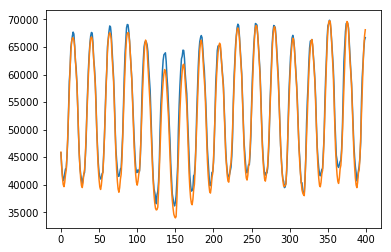

In [561]:
'''
test_pred = XGB_model.predict(X_train)
r2_score(Y_train, test_pred)
plt.plot(test_pred[600:1000])
plt.plot(Y_train[600:1000])
'''

In [99]:
# Calculate the linear transform directly
Y_pred = RF_model.predict(X_valid)
# Y_pred = XGB_model.predict(X_valid)
LR_model = LR().fit(Y_pred.reshape(-1,1), Y_valid.reshape(-1,1))
print('coefficient and intercept of linear model {}, {}'.format(LR_model.coef_, LR_model.intercept_))
print('r2 score: {}'.format(r2_score(Y_valid, LR_model.predict(Y_pred.reshape(-1,1)))))

coefficient and intercept of linear model [[1.04190105]], [415.05265223]
r2 score: 0.9749121539651394


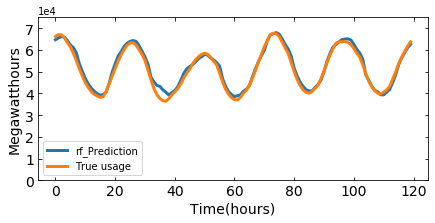

In [100]:
# Visualize the prediction.
X_visualize = X_valid[1080:1200]
Y_visualize = Y_valid[1080:1200]
# plt.figure(figsize=(15,7))
plt.figure(figsize=(7,3))
Y_predict_rf = RF_model.predict(X_visualize)
# Y_predict_knn = KNN_model.predict(X_visualize)
# Y_predict = my_estimator.predict(X_visualize, Y_visualize)
# Y_predict_xgb = XGB_model.predict(X_visualize)

plt.plot(LR_model.predict(Y_predict_rf.reshape(-1,1)), linewidth=3)
# plt.plot(Y_predict_xgb*1.0188164+1289, linewidth=2)
# plt.plot(Y_predict_knn*1.0434171+350, linewidth=4)
plt.plot(Y_visualize, linewidth=3)
# plt.plot(X_visualize[:,3]*100)
plt.xlabel('Time(hours)', fontsize=14)
plt.ylabel('Megawatthours', fontsize=14)
plt.legend(['rf_Prediction','True usage'])
# plt.xlim([1000,1300])
plt.ylim([0,75000])

# Adjust the display style
plt.tick_params(which = 'both',top=True,right=True,direction='in')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

### Construct a time series to predict the linear transform

In [101]:
# Save the random forest model
with open('models/rf_pred_mt', 'wb') as file:
    pickle.dump(RF_model, file)
# Save the linear regression model
with open('models/lr_correction_mt', 'wb') as file:
    pickle.dump(LR_model, file)

## For automatically linear scaling

In [137]:
my_estimator = elec_forcast(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=0.3, random_state=10).fit(X_train, Y_train)

In [138]:
Y_pred = my_estimator.predict(X_train, Y_train)
print('Num of train data: {}. Num of predictions: {}'.format(train_index, len(Y_pred)))

Num of train data: 23175. Num of predictions: 23151


In [27]:
# Perform grid search to look for the best parameters
grid = {'n_estimators': [200],
       'min_samples_split': [2,4],
       'min_samples_leaf': [1,2],
       'max_features': [0.3,0.5,0.7],
       'random_state': [10]}

max_r2 = -np.inf
best_params = None
best_beta = None
bar = tqdm_notebook(total=2*2*3)

for beta in [0.83,0.84,0.85]:
    X_train, Y_train, X_valid, Y_valid = building_temp(beta)
    train_end = len(X_train)
    valid_end = train_end+len(Y_valid)
    train_ind = np.arange(train_end)
    valid_ind = np.arange(train_end, valid_end)
    # Concatenate the train and validation set.
    X_total = np.concatenate((X_train, X_valid), axis=0)
    Y_total = np.concatenate((Y_train, Y_valid))
    search = GridSearchCV(elec_forcast(), grid, cv=[(train_ind, valid_ind)], n_jobs=4, verbose=10)
    search.fit(X_total, Y_total)
    # The best parameters.
    r2 = search.best_score_
    p = search.best_params_
    if max_r2 < r2:
        max_r2 = r2
        best_params = p
        best_beta = beta
    print('Best R2 score {} for {}.'.format(r2, beta))
    
    bar.update(3*2**4)
bar.close()
        
print('The maximum R2 score is: {} \n The best parameters are: {} \n The best beta is: {}'.format(max_r2, best_params, best_beta))

Fitting 1 folds for each of 12 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done   7 out of  12 | elapsed:  2.8min remaining:  2.0min
[Parallel(n_jobs=4)]: Done   9 out of  12 | elapsed:  3.9min remaining:  1.3min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  4.0min finished


Best R2 score 0.9937477777336188 for 0.83.
Fitting 1 folds for each of 12 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done   7 out of  12 | elapsed:  5.9min remaining:  4.2min
[Parallel(n_jobs=4)]: Done   9 out of  12 | elapsed:  8.7min remaining:  2.9min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  8.8min finished


Best R2 score 0.9938003929504793 for 0.84.
Fitting 1 folds for each of 12 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done   7 out of  12 | elapsed:  6.2min remaining:  4.5min
[Parallel(n_jobs=4)]: Done   9 out of  12 | elapsed:  9.6min remaining:  3.2min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  9.7min finished


Best R2 score 0.9938256068720747 for 0.85.

The maximum R2 score is: 0.9938256068720747 
 The best parameters are: {'random_state': 10, 'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 0.3, 'min_samples_split': 2} 
 The best beta is: 0.85


In [28]:
best_params

{'max_features': 0.3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200,
 'random_state': 10}

# Analyze the Present Data

In [43]:
# Load the electricity data from Sep 17 to Sep 24
elec_present = pd.read_csv('electricity_data/texas_sep_18.csv')

In [44]:
elec_present.head(1)

,Region Code,Timestamp (Hour Ending),Demand (MWh),Demand Forecast (MWh),Net Generation (MWh),Total Interchange (MWh)
0,TEX,9/16/2019 12 AM CDT,47548,47905.0,47125.0,-424.0


In [45]:
elec_present.columns

Index(['Region Code', 'Timestamp (Hour Ending)', 'Demand (MWh)',
       'Demand Forecast (MWh)', 'Net Generation (MWh)',
       'Total Interchange (MWh)'],
      dtype='object')

In [46]:
elec_present = elec_present.loc[:,['Timestamp (Hour Ending)', 'Demand (MWh)', 'Demand Forecast (MWh)']]

In [47]:
elec_present = elec_present.rename(columns={'Timestamp (Hour Ending)':'datetime','Demand (MWh)':'usage','Demand Forecast (MWh)':'prediction'})

In [48]:
elec_present['datetime'] = pd.to_datetime(elec_present['datetime'], format='%m/%d/%Y %I %p CDT')
elec_present['time'] = elec_present['datetime'].apply(lambda x:x.hour)
elec_present['month'] = elec_present['datetime'].apply(lambda x:x.month)
elec_present['weekday'] = elec_present['datetime'].apply(lambda x:x.weekday())
elec_present['year'] = elec_present['datetime'].apply(lambda x:x.year)
elec_present['day'] = elec_present['datetime'].apply(lambda x:x.day)

In [49]:
# Load the weather data
weather_sep_18 = pd.read_csv('electricity_data/weather_sep_18.csv')
# Round the date info
weather_sep_18['datetime'] = pd.to_datetime(weather_sep_18['DATE'], format='%Y-%m-%dT%H:%M:%S')
weather_sep_18['date'] = weather_sep_18['datetime'].apply(lambda date_time: round_time(date_time))
weather_sep_18['time'] = weather_sep_18['date'].apply(lambda x:x.hour)
weather_sep_18['month'] = weather_sep_18['date'].apply(lambda x:x.month)
weather_sep_18['day'] = weather_sep_18['date'].apply(lambda x:x.day)
# weather_sep_18['weekday'] = weather_sep_18['date'].apply(lambda x:x.weekday())
weather_sep_18['year'] = weather_sep_18['date'].apply(lambda x:x.year)
weather_sep_18['HourlyDryBulbTemperature'] = weather_sep_18['HourlyDryBulbTemperature'].apply(lambda s:parse_temperature(s))
weather_sep_18 = weather_sep_18.loc[weather_sep_18['HourlyDryBulbTemperature'].notna(),:]
weather_sep_18 = weather_sep_18[useful_columns]
weather_sep_18 = weather_sep_18[useful_columns].groupby(match_columns+['STATION'], as_index=False).mean()
houston = weather_sep_18.loc[weather_sep_18['STATION'] == 72243012960,:]
san_antonio = weather_sep_18.loc[weather_sep_18['STATION'] == 72259003927,:]
dallas = weather_sep_18.loc[weather_sep_18['STATION'] == 72253012921,:]
df_sep_18 = elec_present.merge(houston, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.merge(san_antonio, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.merge(dallas, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.drop(columns=['STATION_x', 'STATION_y', 'STATION']).rename(columns={'HourlyDryBulbTemperature_x':'T_1','HourlyDryBulbTemperature_y':'T_3','HourlyDryBulbTemperature':'T_2'})
df_sep_18 = df_sep_18.sort_values('datetime')

In [50]:
df_sep_18.head(1)

,datetime,usage,prediction,time,month,weekday,year,day,T_1,T_3,T_2
0,2019-09-16,47548,47905.0,0,9,0,2019,16,76.0,83.0,79.0


In [51]:
X_present = df_sep_18[features].values
Y_present = df_sep_18['usage'].values
column = 3
X_present, Y_present = attenuate(X_present, Y_present, beta, column)
Y_web_pred = df_sep_18['prediction'].values[25:]

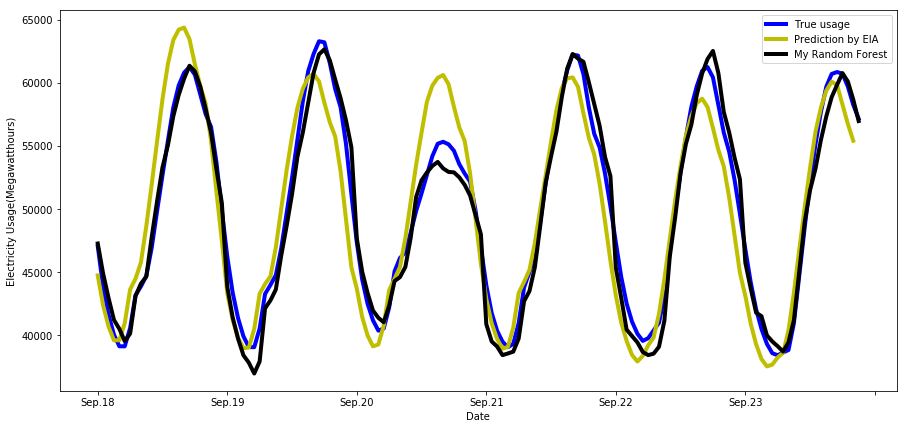

In [53]:
from matplotlib.ticker import MultipleLocator

# Y_pred = XGB_model.predict(X_present)
Y_pred = RF_model.predict(X_present)
fig,ax = plt.subplots(figsize=(15,7))
plt.plot(Y_present, 'b', linewidth=4)
plt.plot(Y_web_pred, 'y', linewidth=4)
plt.plot(Y_pred*1.07368297-420, 'black', linewidth=4)
plt.xlabel('Date')
plt.ylabel('Electricity Usage(Megawatthours)')
plt.legend(['True usage', 'Prediction by EIA', 'My Random Forest'])
ax.xaxis.set_major_locator(MultipleLocator(24))
ax.set_xticklabels(['', 'Sep.18', 'Sep.19', 'Sep.20', 'Sep.21', 'Sep.22', 'Sep.23'])
plt.show()

## Time Series Model

In [102]:
electricity_demand_sorted = electricity_demand.sort_values(['datetime']).reset_index(drop=True)

In [103]:
electricity_demand_sorted.head(3)

,datetime,usage,time,month,weekday,year,day,normalized_usage
0,2015-07-01 01:05:00,37456,1,7,2,2015,1,0.255033
1,2015-07-01 02:05:00,35119,2,7,2,2015,1,0.208077
2,2015-07-01 03:05:00,33638,3,7,2,2015,1,0.178320


In [45]:
# Make sure there is no missed hours.
wrong_intervals = []

for ind in np.arange(len(electricity_demand_sorted)-1):
    if electricity_demand_sorted.iloc[ind]['datetime']+timedelta(hours=1) != electricity_demand_sorted.iloc[ind+1]['datetime']:
        wrong_intervals.append(ind)

In [46]:
print('Wrong intervals: {}'.format(len(wrong_intervals)))

Wrong intervals: 10


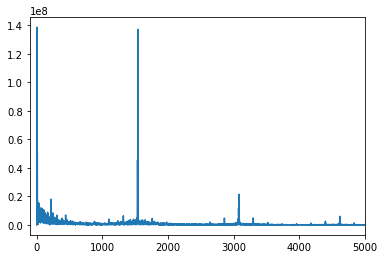

In [47]:
mean_removed = electricity_demand_sorted['usage'].values - np.mean(electricity_demand_sorted['usage'].values)
fft = np.absolute(np.fft.fft(mean_removed))
plt.plot(fft)
_ = plt.xlim([-100,5000])

In [48]:
# Peak for the daily cycle
daily_peak = np.where((fft < -3e7) | (fft > 1e7))[0]
print('the preak corresponding to the daily cycle: {}'.format(daily_peak))

the preak corresponding to the daily cycle: [    1     2     3     4     5     7     8     9    10    11    12    16
    18    21    33    41    55    60    76   102   115   219   220  1534
  1535  1536  1539  1541  1542  1543  3074  3078  3082 33853 33857 33861
 35392 35393 35394 35396 35399 35400 35401 36715 36716 36820 36833 36859
 36875 36880 36894 36902 36914 36917 36919 36923 36924 36925 36926 36927
 36928 36930 36931 36932 36933 36934]


3 corresponding to something around 1.4 year
4 corresponding to something around 1.05 year
8 corresponding to something around 0.53 year ->
9 corresponding to something around 0.46 year -> These two should be corresponding to the half a year period (check whether there are pseudo periods)
220 corresponding to the weekly period (not that strong compared to the daily peak)
1539 corresponding to the daily period

## Check to see how many harmonics we should include

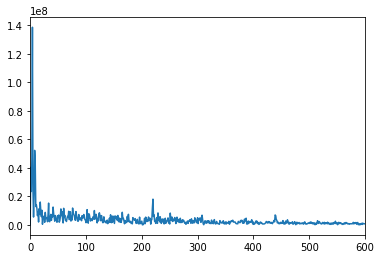

In [647]:
plt.plot(fft)
_ = plt.xlim([0,600])

Let's fit a periodic model first.<br>
three harmonics for the yearly cycle and two harmonics for the weekly and daily cycle.<br>
Try the first three years as the training set first

In [49]:
df_for_periodic_model = df_joined[['datetime','usage','time','month','weekday','year','day']].copy()

In [50]:
def diff_in_hours(x):
    # This function returns the number of hours from 2015-07-01 01:05:00
    minutes = (x-datetime(2015, 7, 1, 1, 5, 0)).total_seconds()/60
    if minutes % 60 > 30:
        return minutes/60 + 1
    else:
        return minutes/60
    
df_for_periodic_model['hours'] = df_for_periodic_model['datetime'].apply(lambda x: diff_in_hours(x))

In [51]:
# Construct the sin and cos columns.
def trig(func, period, x):
    # This function returns a sin or x value of x.
    return func(2*np.pi*x/period)

# Yearly period.
df_for_periodic_model['yearly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24, x))
df_for_periodic_model['yearly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24, x))
df_for_periodic_model['yearly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24/2, x)) # Starting from here are harmonics
df_for_periodic_model['yearly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24/2, x))
df_for_periodic_model['yearly_3_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24/3, x))
df_for_periodic_model['yearly_3_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24/3, x))
# Weekly period.
df_for_periodic_model['weekly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24, x))
df_for_periodic_model['weekly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24, x))
df_for_periodic_model['weekly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24/2, x))
df_for_periodic_model['weekly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24/2, x))
# Dayly period.
df_for_periodic_model['dayly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24, x))
df_for_periodic_model['dayly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24, x))
df_for_periodic_model['dayly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/2, x))
df_for_periodic_model['dayly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/2, x))
df_for_periodic_model['dayly_3_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/3, x))
df_for_periodic_model['dayly_3_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/3, x))
df_for_periodic_model['dayly_4_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/4, x))
df_for_periodic_model['dayly_4_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/4, x))

In [52]:
df_for_periodic_model.head(3)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,...,weekly_2_sin,weekly_2_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos
0,2015-07-01 01:05:00,37456,1,7,2,2015,1,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.0
1,2015-07-01 02:05:00,35119,2,7,2,2015,1,1.0,0.000717,1.000000,...,0.074730,0.997204,0.258819,0.965926,0.500000,0.866025,0.707107,7.071068e-01,0.866025,0.5
2,2015-07-01 03:05:00,33638,3,7,2,2015,1,2.0,0.001434,0.999999,...,0.149042,0.988831,0.500000,0.866025,0.866025,0.500000,1.000000,6.123234e-17,0.866025,-0.5


There is a slowly varying trend which should be handled first using a ridge regression.

In [53]:
df_for_periodic_model.tail(1)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,...,weekly_2_sin,weekly_2_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos
36934,2019-09-18 23:05:00,51199,23,9,2,2019,18,36982.0,0.980846,0.194783,...,0.997204,-0.07473,-0.5,0.866025,-0.866025,0.5,-1.0,4.291705e-13,-0.866025,-0.5


In [54]:
# Produce the x^2 and X^3 term for the ridge regressor

df_for_periodic_model['scaled_hours'] = df_for_periodic_model['hours']/100
df_for_periodic_model['scaled_hours_squared'] = df_for_periodic_model['scaled_hours']**2
df_for_periodic_model['scaled_hours_cubic'] = df_for_periodic_model['scaled_hours']**3

In [55]:
columns_x = ['scaled_hours', 'scaled_hours_squared', 'scaled_hours_cubic']
X = df_for_periodic_model[columns_x].values
y = df_for_periodic_model['usage'].values/1e4

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# search = GridSearchCV(Line, params, cv=5, n_jobs=4, verbose=10)
# _ = search.fit(X,y)
linear_trend = LinearRegression().fit(X[:,0].reshape(-1,1), y)

In [68]:
'''
# Save the linear trend model.
with open('models/lr_yearly_trend', 'wb') as file:
    pickle.dump(linear_trend, file)
print(linear_trend.coef_, linear_trend.intercept_)
'''

"\n# Save the linear trend model.\nwith open('models/lr_yearly_trend', 'wb') as file:\n    pickle.dump(linear_trend, file)\nprint(linear_trend.coef_, linear_trend.intercept_)\n"

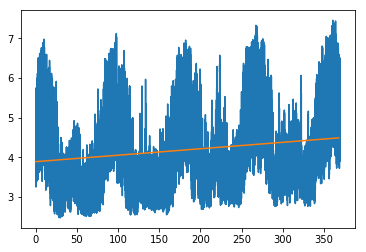

In [57]:
plt.plot(X[:,0],y)
X_sample = np.arange(int(X[-1,0]))
_ = plt.plot(X_sample, linear_trend.predict(X_sample.reshape(-1,1)))
# plt.xlim([10,20])

In [58]:
def remove_trend(row):
    return row['usage']-(row['scaled_hours']*linear_trend.coef_[0]+linear_trend.intercept_)*1e4

df_for_periodic_model['usage_trend_removed'] = df_for_periodic_model[['usage','scaled_hours']].apply(lambda row: remove_trend(row), axis=1)

# Split the train, test and validation set

df_train = df_for_periodic_model.iloc[:train_index]
df_valid = df_for_periodic_model.iloc[valid_index]
df_test = df_for_periodic_model.iloc[test_index]

In [59]:
df_train.head(1)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,...,dayly_2_sin,dayly_2_cos,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos,scaled_hours,scaled_hours_squared,scaled_hours_cubic,usage_trend_removed
0,2015-07-01 01:05:00,37456,1,7,2,2015,1,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1472.100301


In [60]:
columns_x = []
for column in df_train.columns:
    if column.endswith('sin') or column.endswith('cos'):
        columns_x.append(column)

In [61]:
X = df_train[columns_x].values
y = df_train['usage_trend_removed'].values

period_model = LinearRegression().fit(X,y)

In [726]:
'''
# Save the periodic model.
with open('models/lr_periodic', 'wb') as file:
    pickle.dump(period_model, file)
period_model.coef_
'''

array([ 3822.83604568,  6415.74343488,  2829.97127622,  2983.7425974 ,
        -150.47796848,  -636.25863834,   762.91107545,  1112.38685029,
        -632.35357521,  -230.59493791, -5891.27457796, -4097.08841978,
       -1057.14434828,  -703.97795873,  -297.56746269,  -163.56283538,
          89.90482678,    20.77253358])

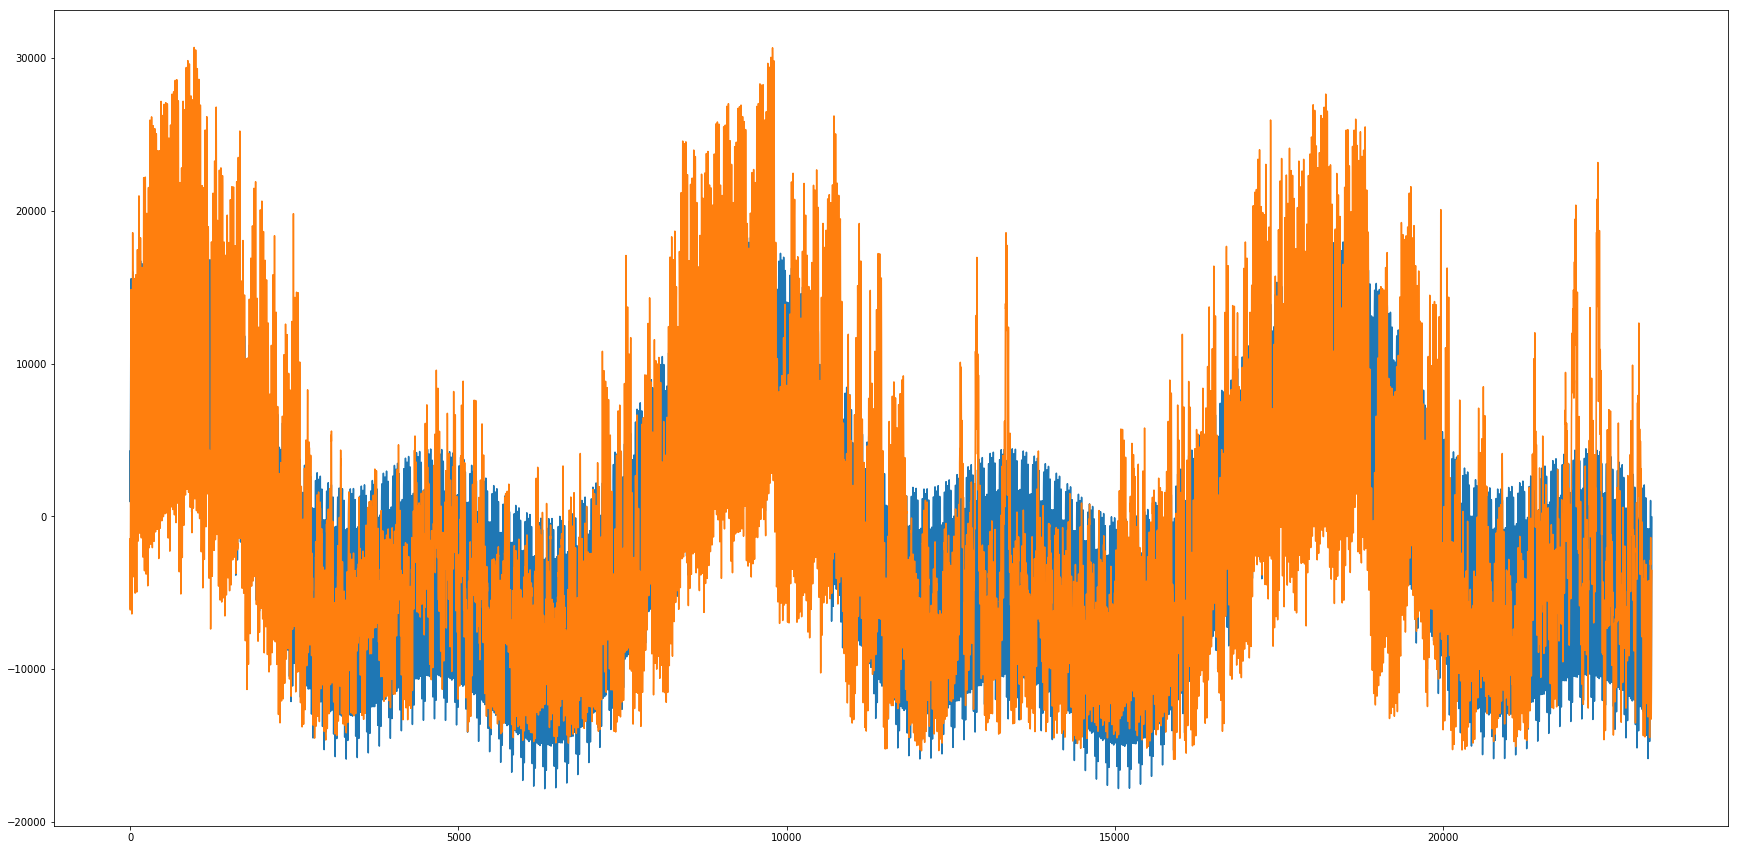

In [62]:
from sklearn.metrics import r2_score

# Plot the prediction for the train data
#df_valid = df_valid.reset_index(drop=True)
samples_X = df_train.loc[:, columns_x].values
samples_Y = df_train.loc[:, 'usage_trend_removed'].values
train_pred = period_model.predict(samples_X)
df_train['prediction'] = train_pred

plt.subplots(figsize=(30,15))
plt.plot(train_pred)
_ = plt.plot(samples_Y)

# r2_score(samples_Y, pred_Y)

Notice that the amplitude in summer is larger than the amplitude in winter. Fit a linear regression to each days true usage and prediction.

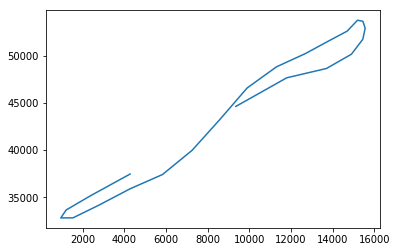

In [63]:
# plot the prediction and true usage for a specific day as an example.
x = df_train.loc[df_train['datetime'] < datetime(2015,7,2,0,0,0), ['usage','prediction']].values
y = x[:,0]
x = x[:,1]
plt.plot(x,y)
plt.show()

In [64]:
from datetime import date

df_train['date'] = df_train['datetime'].apply(lambda x: date(x.year, x.month, x.day))

In [65]:
# aggregate by day.
train_truths = df_train[['date','usage_trend_removed']].groupby(['date'])['usage_trend_removed'].apply(list)
train_preds = df_train[['date','prediction']].groupby(['date'])['prediction'].apply(list)

In [66]:
def linear_adjustment(X,y):
    lr_tool = LR().fit(np.asarray(X).reshape(-1,1),np.asarray(y).reshape(-1,1))
    return lr_tool.coef_[0][0], lr_tool.intercept_

In [67]:
adjustment_coefs = []
adjustment_intercepts = []
for X,y in zip(train_preds, train_truths):
    coef, intercept = linear_adjustment(X,y)
    adjustment_coefs.append(coef)
    adjustment_intercepts.append(intercept)

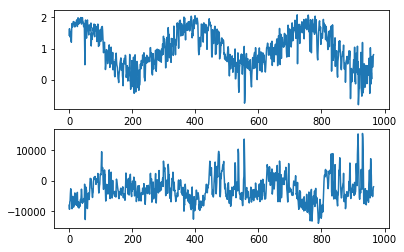

In [68]:
fig, ax = plt.subplots(2,1)
ax[0].plot(adjustment_coefs)
ax[1].plot(adjustment_intercepts)
plt.show()

In [69]:
# Fit three harmonics to both the coeficients and the intercepts.
sin = np.sin(np.arange(len(train_truths))*2*np.pi/365.25).reshape(-1,1)
cos = np.cos(np.arange(len(train_truths))*2*np.pi/365.25).reshape(-1,1)
sin_2 = np.sin(np.arange(len(train_truths))*np.pi/365.25).reshape(-1,1)
cos_2 = np.cos(np.arange(len(train_truths))*np.pi/365.25).reshape(-1,1)
sin_3 = np.sin(np.arange(len(train_truths))*2*np.pi/365.25/3).reshape(-1,1)
cos_3 = np.cos(np.arange(len(train_truths))*2*np.pi/365.25/3).reshape(-1,1)

In [70]:
X = np.concatenate((sin,cos,sin_2,cos_2,sin_3,cos_3), axis=1)

lr_coef = LinearRegression().fit(X, adjustment_coefs)
lr_intercept = LinearRegression().fit(X, adjustment_intercepts)
# Save the linear adjustment models.
'''
with open('models/lr_adjustement_coef', 'wb') as file:
    pickle.dump(lr_coef, file)
    
with open('models/lr_adjustement_intercept', 'wb') as file:
    pickle.dump(lr_intercept, file)
'''

"\nwith open('models/lr_adjustement_coef', 'wb') as file:\n    pickle.dump(lr_coef, file)\n    \nwith open('models/lr_adjustement_intercept', 'wb') as file:\n    pickle.dump(lr_intercept, file)\n"

In [71]:
df_train.head(1)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,...,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos,scaled_hours,scaled_hours_squared,scaled_hours_cubic,usage_trend_removed,prediction,date
0,2015-07-01 01:05:00,37456,1,7,2,2015,1,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1472.100301,4274.424408,2015-07-01


In [72]:
df_train['adjusted_pred'] = df_train['prediction']* \
                            lr_coef.predict(df_train[columns_x[:6]].values).reshape(-1) \
                            + lr_intercept.predict(df_train[columns_x[:6]].values).reshape(-1)

r2_score: 0.7565852088435531


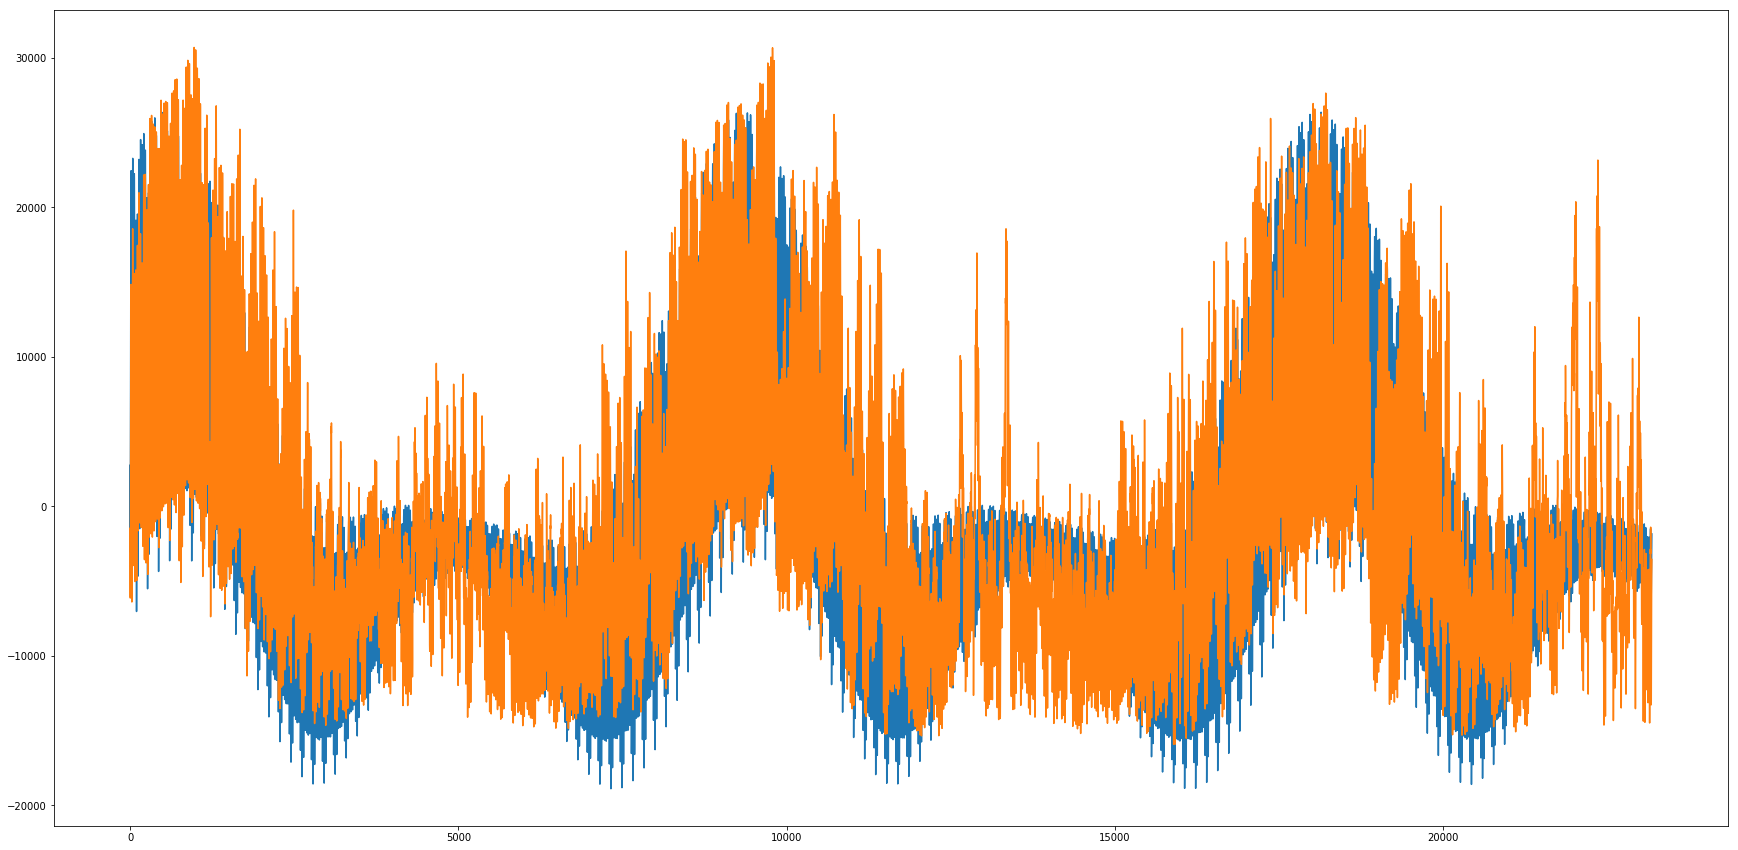

In [73]:
plt.subplots(figsize=(30,15))
plt.plot(df_train['adjusted_pred'].values)
_ = plt.plot(df_train['usage_trend_removed'].values)
print('r2_score: {}'.format(r2_score(df_train['usage_trend_removed'], df_train['adjusted_pred'])))

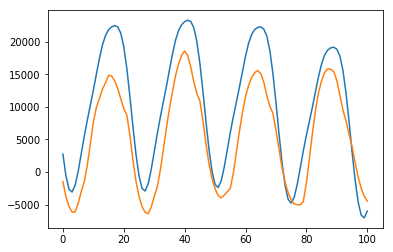

In [74]:
# plot the prediction for the validation data.

# plt.subplots(figsize=(30,15))
plt.plot(df_train.loc[:100, 'adjusted_pred'].values)
_ = plt.plot(df_train.loc[:100, 'usage_trend_removed'].values)

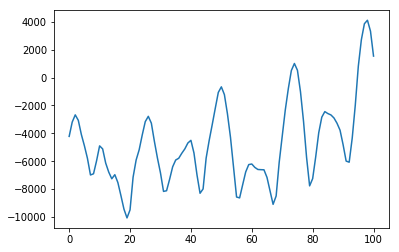

In [75]:
# Plot the residual.
df_train['residual'] = df_train['usage_trend_removed']-df_train['adjusted_pred']
# plt.subplots(figsize=(30,15))
_ = plt.plot(df_train.loc[:100, 'usage_trend_removed'].values-df_train.loc[:100, 'adjusted_pred'].values)

Try auto correlation and partial autocorrelation in the residual to make new discovery.

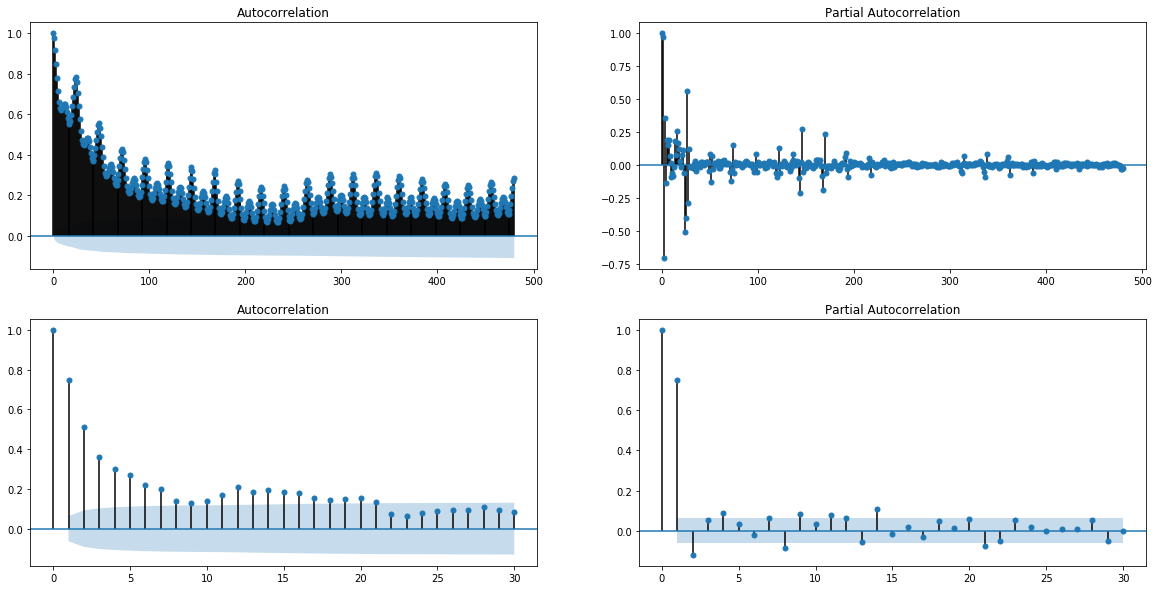

In [677]:
# Autocorrelation and partial autocorrelation of the residual and the residual grouped by hours.

fig, ax = plt.subplots(2,2, figsize=(20,10))
_ = plot_acf(x=df_train['residual'].values, ax=ax[0,0],lags=480)
_ = plot_pacf(x=df_train['residual'].values, ax=ax[0,1], lags=480)
_ = plot_acf(x=df_train.loc[df_train['time'] == 12, 'residual'].values, ax=ax[1,0], lags=30)
_ = plot_pacf(x=df_train.loc[df_train['time'] == 12, 'residual'].values, ax=ax[1,1], lags=30)

upper: 6185.5. lower: -6218.5


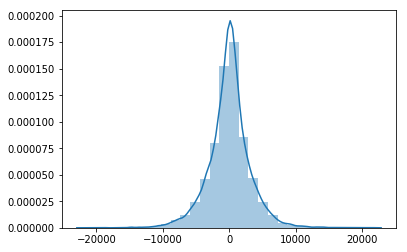

In [76]:
# Construct the distribution of the first order daily differences.
diffs = []
residuals = []
for h in np.arange(24):
    diffs.extend(np.diff(df_train.loc[df_train['time'] == h, 'usage'].values))
    residuals.extend(df_train.loc[df_train['time'] == h, 'residual'].values)

# Boundaries for outliers
qs = np.percentile(diffs, [25,75])
one_q = qs[0]
three_q = qs[1]
upper = 1.5*(three_q-one_q)+three_q
lower = one_q-1.5*(three_q-one_q)
print('upper: {}. lower: {}'.format(upper, lower))
_ = sns.distplot(diffs, bins=30)

In [77]:
# Construct kind of an AR(2) model with data containing outliers removed.
residuals = np.asarray(residuals).reshape(-1,1)
x = np.concatenate((residuals[:-2,:], residuals[1:-1,:], residuals[2:,:]), axis=1)
diffs_x = np.maximum(np.absolute(x[:,1]-x[:,0]), np.absolute(x[:,2]-x[:,1]))

x = x[diffs_x < (upper-lower)/2]
y = x[:,2]
x = x[:,:2]

lr_ar2 = LinearRegression(fit_intercept=False).fit(x,y)
print('Parameters: {}, {}'.format(lr_ar2.coef_, lr_ar2.intercept_))
print('r2_score: {}'.format(r2_score(y,lr_ar2.predict(x))))

Parameters: [-0.1186524   0.96406316], 0.0
r2_score: 0.745347993421737


In [728]:
'''
# Save the AR(2) model.
with open('models/lr_ar2', 'wb') as file:
    pickle.dump(lr_ar2, file)
'''

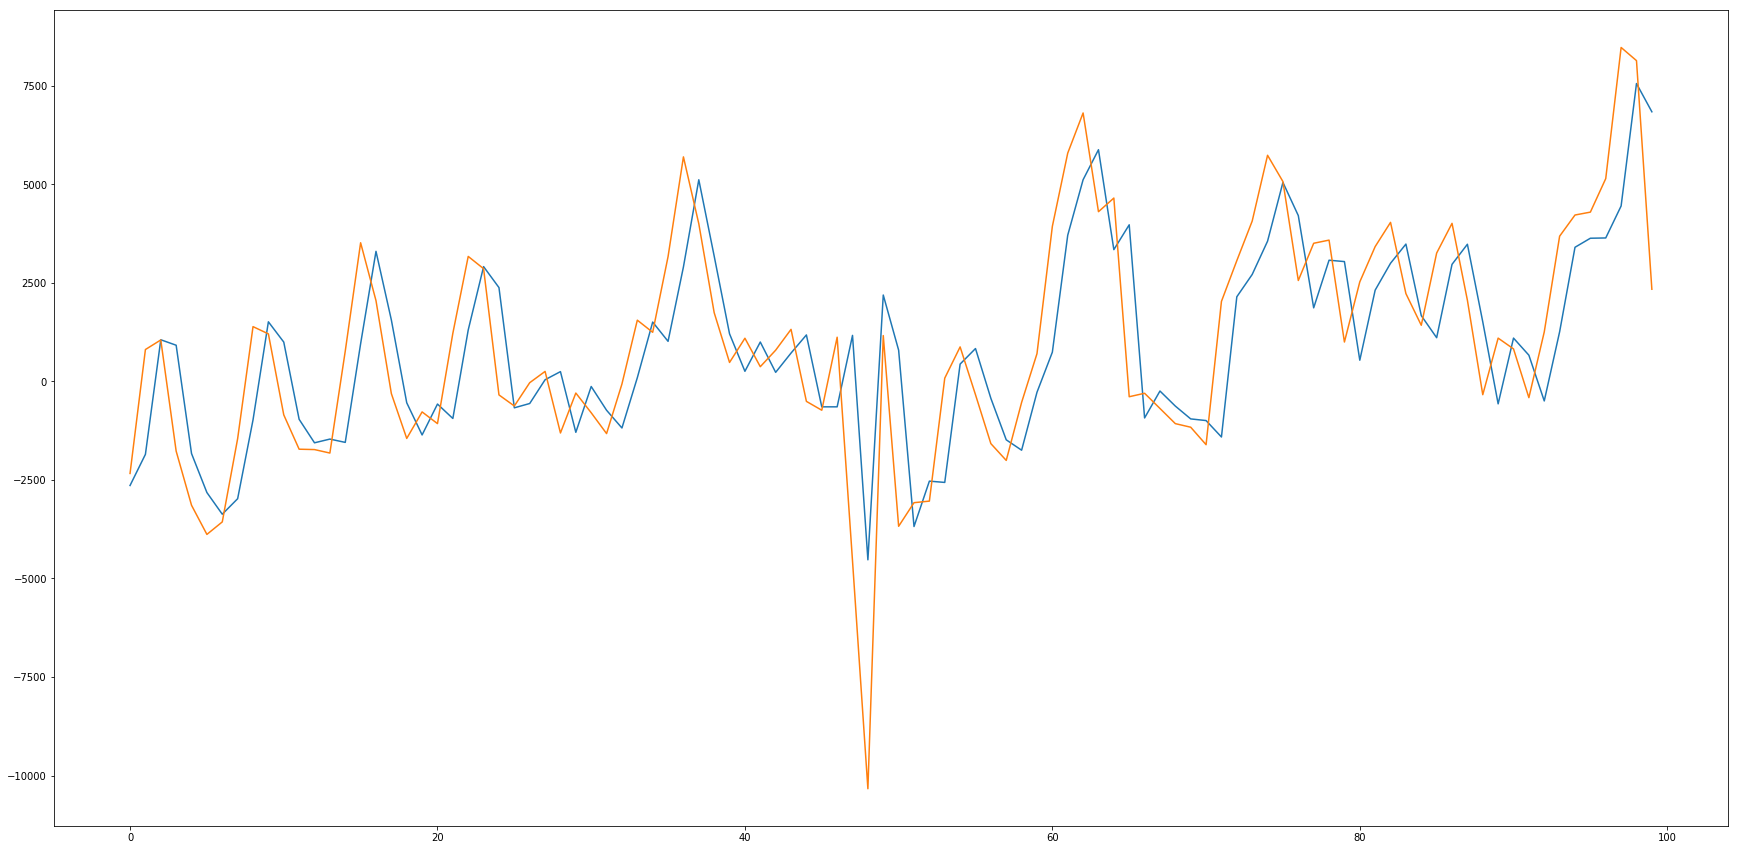

In [78]:
x_preds = lr_ar2.predict(x)
plt.subplots(figsize=(30,15))
plt.plot(x_preds[:100])
_ = plt.plot(y[:100])

## Test the time series model on the validation set.

In [104]:
df_valid['prediction'] = period_model.predict(df_valid[columns_x].values)
df_valid['adjusted_pred'] = df_valid['prediction']* \
                            lr_coef.predict(df_valid[columns_x[:6]].values).reshape(-1) \
                            + lr_intercept.predict(df_valid[columns_x[:6]].values).reshape(-1)

In [105]:
df_valid = df_valid.reset_index(drop=True).reset_index().rename(columns={'Unnamed: 0': 'index'})
df_valid = df_valid.drop(columns=['index']).reset_index(drop=True).reset_index().rename(columns={'Unnamed: 0': 'index'})

In [106]:
df_valid['residual'] = df_valid['usage_trend_removed']-df_valid['adjusted_pred']

In [107]:
def predict_residual(df):
    # Predict the residual of the periodic model.
    residual_pred = np.asarray([[-1,-1,-1,-1]])

    for h in np.arange(24):
        # make predictions.
        x = df.loc[df['time'] == h, ['index', 'residual']].values
        index = x[2:,0].reshape(-1,1)
        x = np.concatenate((x[0:-2,1].reshape(-1,1), x[1:-1,1].reshape(-1,1)), axis=1)
        y = lr_ar2.predict(x)

        # go through the list and correct the days with sudden weather change with the previous prediction values.
        # which means we don't alter our prediction facing a sudden weather change, unless the change persists for two days.
        # for ind in np.arange(1, len(x)):
          #  if abs(x[ind,1]-x[ind,0]) > (upper-lower)/2:
           #     y[ind] = y[ind-1]

        y = np.concatenate((index, y.reshape(-1,1), x), axis=1)
        residual_pred = np.concatenate((residual_pred,y), axis=0)

    return pd.DataFrame(residual_pred, columns=['index','residual_pred','t_2', 't_1'])

In [108]:
df_joined = df_joined.reset_index(drop=True)
index = np.arange(48, len(valid_index))
X_temp_valid = df_joined[features[3:]].values[valid_index,:]
x, y = attenuate(df_joined.loc[valid_index,features].values, df_joined.loc[valid_index,'usage'].values, 0.84, 3)
Y_pred_valid = LR_model.predict(RF_model.predict(x).reshape(-1,1))
X_temp_valid = np.concatenate((index.reshape(-1,1), X_temp_valid[48:,:], X_temp_valid[24:-24,:], X_temp_valid[48,:]-X_temp_valid[24:-24,:], Y_pred_valid[24:].reshape(-1,1)), axis=1)
unioned_columns = ['index']
for x in range(X_temp_valid.shape[1]-1):
    unioned_columns.append(str(x))
df_X_temp_valid = pd.DataFrame(X_temp_valid, columns=unioned_columns)

In [109]:
df_X_temp_valid.columns

Index(['index', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')

In [110]:
df_residual = predict_residual(df_valid)
df_valid_tspred = df_valid.merge(df_X_temp_valid, how='left', left_on='index', right_on='index')
df_valid_tspred = df_valid_tspred.merge(df_residual, how='inner', left_on='index', right_on='index')

In [111]:
df_valid_tspred[['usage', '9']].head(10)

,usage,9
0,44545,42961.092444
1,44399,42398.741981
2,44745,42361.238753
3,45299,43278.590951
4,46576,44342.038515
5,46651,44531.831210
6,45817,44497.797512
7,43973,43833.955468
8,41353,42705.342203
9,38822,38682.239260


(1000, 2000)

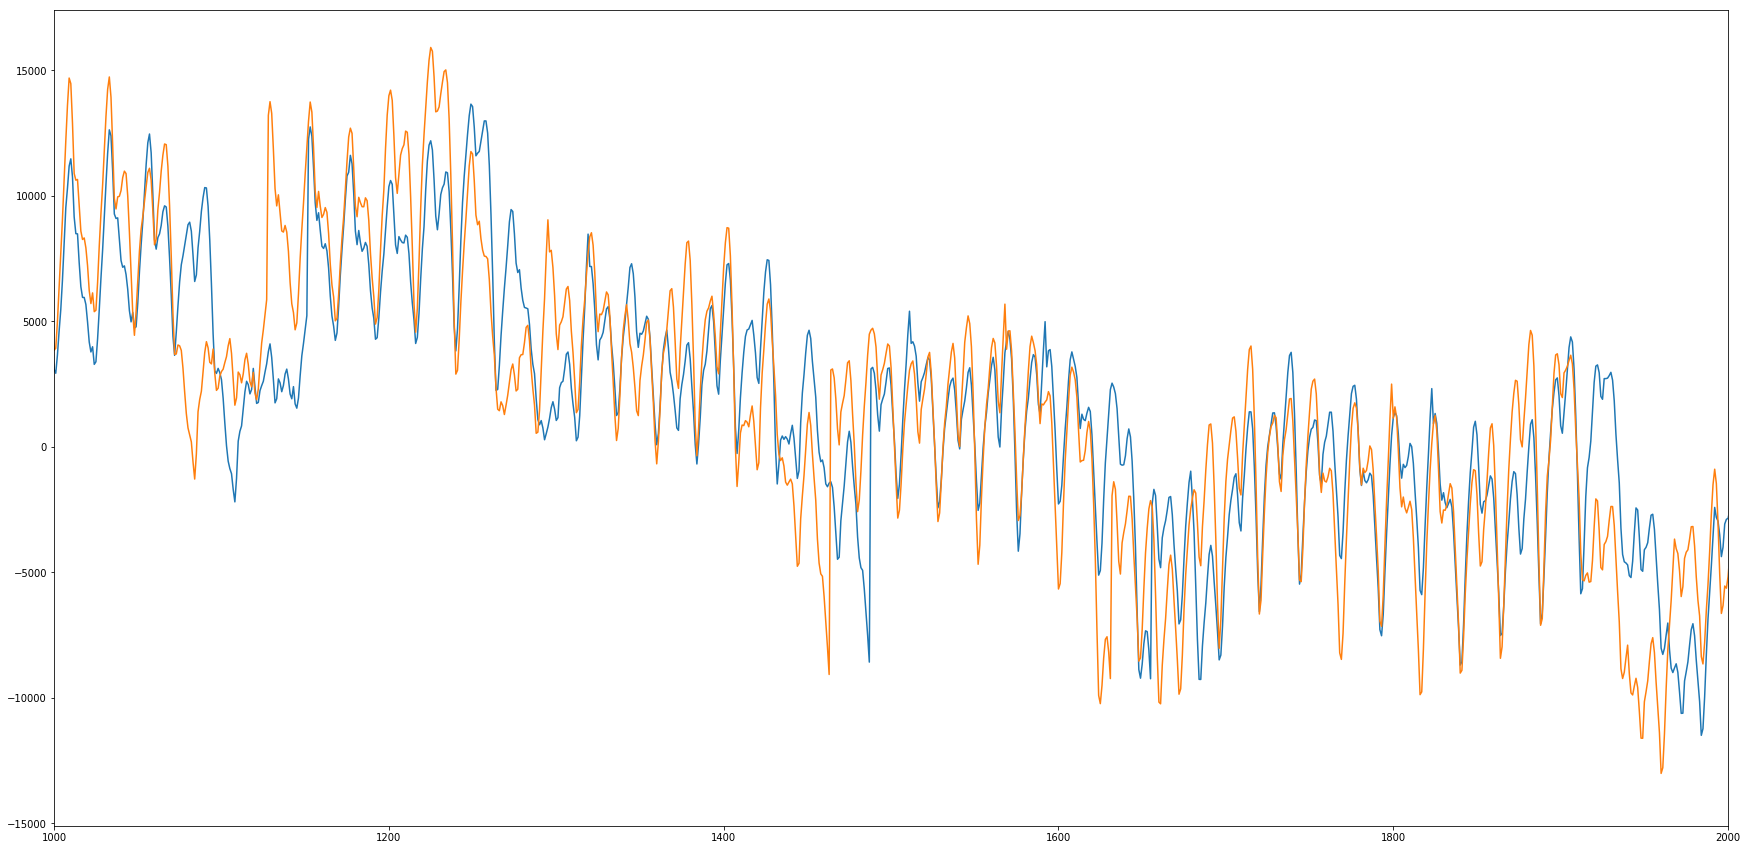

In [112]:
plt.subplots(figsize=(30,15))
plt.plot(df_valid_tspred['residual_pred'])
plt.plot(df_valid_tspred['residual'])
plt.xlim(1000,2000)

r2_score: 0.8989553687634065


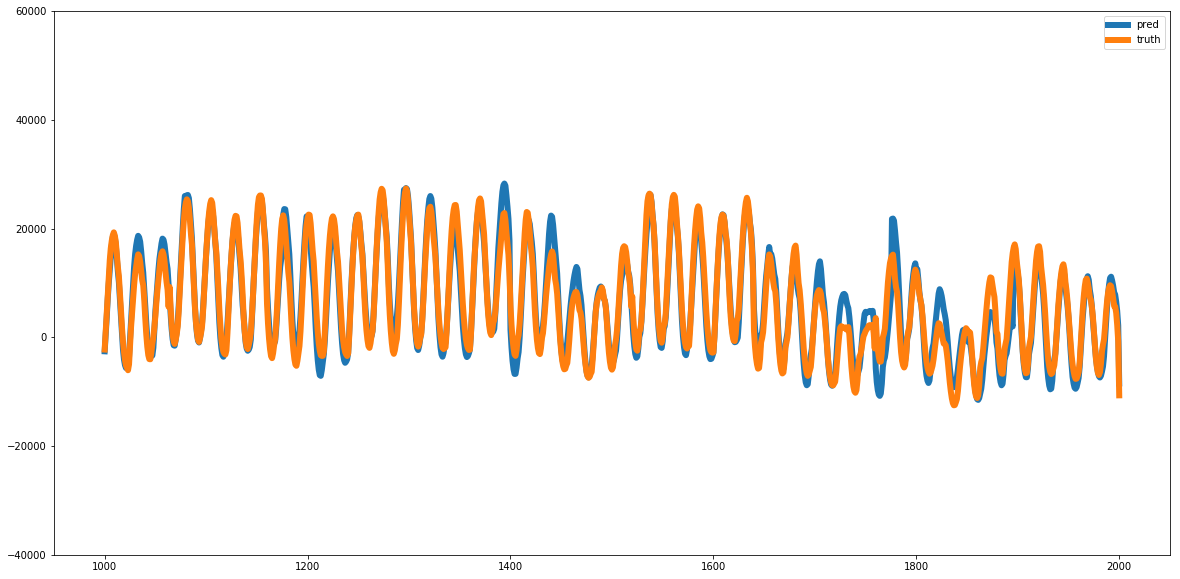

In [113]:
df_valid_tspred['ts_pred'] = df_valid_tspred['adjusted_pred']+df_valid_tspred['residual_pred']
# Remove all the Tuesday and Wednesday.
df_valid_tspred = df_valid_tspred.loc[(df_valid_tspred['weekday'] != 1) & (df_valid_tspred['weekday'] != 2),:]
df_valid_tspred = df_valid_tspred.reset_index(drop=True)

print('r2_score: {}'.format(r2_score(df_valid_tspred['usage_trend_removed'], df_valid_tspred['ts_pred'])))

plt.subplots(figsize=(20,10))
plt.plot(df_valid_tspred.loc[1000:2000, 'ts_pred'], linewidth=6)
plt.plot(df_valid_tspred.loc[1000:2000, 'usage_trend_removed'], linewidth=6)
plt.ylim([-40000,60000])
plt.legend(['pred', 'truth'])
plt.show()

## Ensemble the random forest model and the time series model

In [148]:
df_train = df_train.reset_index(drop=True).rename(columns={'Unnamed: 0':'index'})
df_train = df_train.reset_index().rename(columns={'Unnamed: 0':'index'})
df_train = df_train.drop(columns=['index']).reset_index().rename(columns={'Unnamed: 0':'index'})
df_residual = predict_residual(df_train)
df_tspred_final = df_train.merge(df_residual, how='inner', left_on='index', right_on='index')

ValueError: cannot insert level_0, already exists

In [115]:
df_tspred_final.head(1)

,index,level_0,datetime,usage,time,month,weekday,year,day,hours,...,scaled_hours_squared,scaled_hours_cubic,usage_trend_removed,prediction,date,adjusted_pred,residual,residual_pred,t_2,t_1
0,48,48,2015-07-03 01:05:00,40173,1,7,4,2015,3,48.0,...,0.2304,0.110592,1237.100934,4674.111706,2015-07-03,3444.186603,-2207.085669,-3476.677715,-4220.306933,-4125.691597


In [116]:
Y_pred = RF_model.predict(X_train).reshape(-1,1)
df_tspred_final['rf_pred'] = Y_pred[24:]

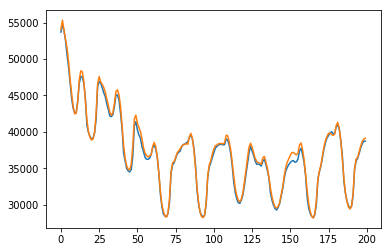

In [117]:
test_X = df_tspred_final['rf_pred'].values
test_y = df_tspred_final['usage'].values

plt.plot(test_X[-200:])
plt.plot(test_y[-200:])

In [118]:
def add_trend(row):
    return row['residual_pred']+row['adjusted_pred']+(row['scaled_hours']*linear_trend.coef_[0]+linear_trend.intercept_)*1e4

df_tspred_final['ts_pred'] = df_tspred_final.apply(lambda row: add_trend(row), axis=1)

In [119]:
def ts_or_rf(row):
    if abs(row['ts_pred']-row['usage']) <= abs(row['rf_pred']-row['usage']):
        return 1 # The time series model is better.
    else:
        return 0 # The random forest model is better
    
def ensemble_pred(row):
    if abs(row['ts_pred']-row['usage']) <= abs(row['rf_pred']-row['usage']):
        return row['ts_pred']
    else:
        return row['rf_pred']    

df_tspred_final['ts_or_rf'] = df_tspred_final.apply(lambda row: ts_or_rf(row), axis=1)
df_tspred_final['ensemble_pred'] = df_tspred_final.apply(lambda row: ensemble_pred(row), axis=1)

In [120]:
sum(df_tspred_final['ts_or_rf'] == 1)

3032

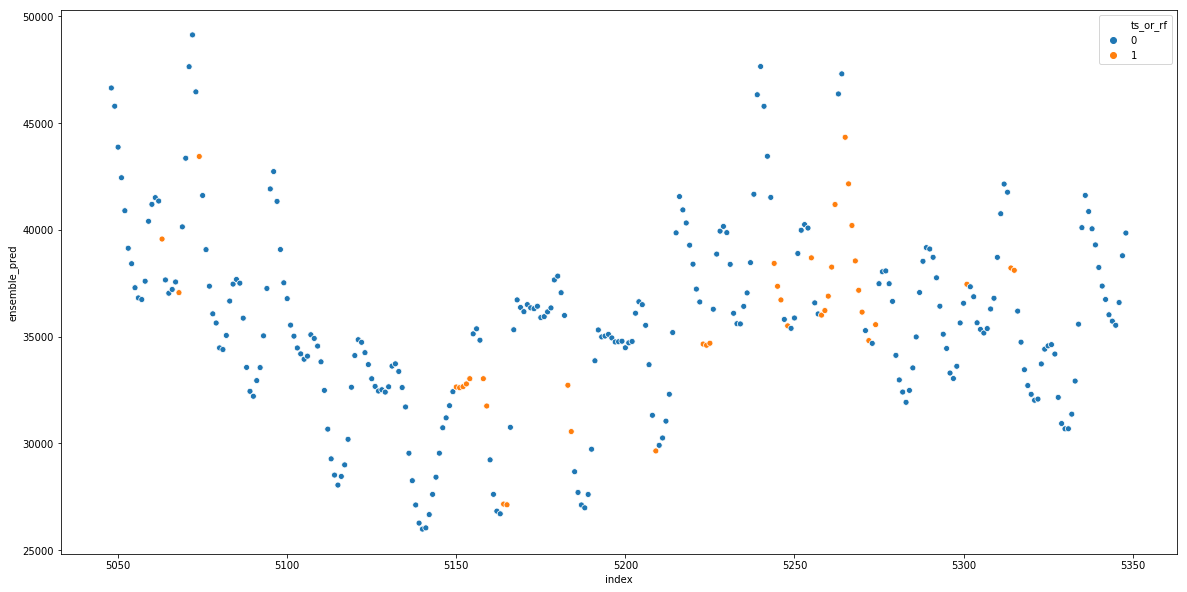

In [108]:
'''
plt.subplots(figsize=(20,10))
d = df_tspred_final.loc[df_tspred_final['ts_or_rf'] == 1, ['index', 'ts_pred']].values
plt.plot(df_tspred_final.loc[:300,'ts_pred'], 'b')
# d = df_tspred_final.loc[df_tspred_final['ts_or_rf'] == 0, ['index', 'ts_pred']].values
plt.plot(df_tspred_final.loc[:300,'rf_pred'], 'r')
plt.plot(df_tspred_final.loc[:300,'usage'], 'y')
# plt.xlim([48,500])
plt.show()
'''
plt.subplots(figsize=(20,10))
_ = sns.scatterplot(x='index', y='ensemble_pred', hue='ts_or_rf', data= df_tspred_final.loc[5000:5300,:])

In [121]:
X_temp = df_joined[features[3:]].values[:train_index,:]
X_temp = np.concatenate((X_temp[48:,:], X_temp[24:-24,:], X_temp[48,:]-X_temp[24:-24,:]), axis=1) # concatenate the temperatures 24 hours ago to the current temperature.

In [122]:
df_valid_tspred['ts_pred'] = df_valid_tspred.apply(lambda row: add_trend(row), axis=1)

In [123]:
df_valid_tspred['t2-t1'] = df_valid_tspred['t_2'] - df_valid_tspred['t_1']

In [124]:
df_valid_tspred.columns

Index(['index', 'level_0', 'datetime', 'usage', 'time', 'month', 'weekday',
       'year', 'day', 'hours', 'yearly_sin', 'yearly_cos', 'yearly_2_sin',
       'yearly_2_cos', 'yearly_3_sin', 'yearly_3_cos', 'weekly_sin',
       'weekly_cos', 'weekly_2_sin', 'weekly_2_cos', 'dayly_sin', 'dayly_cos',
       'dayly_2_sin', 'dayly_2_cos', 'dayly_3_sin', 'dayly_3_cos',
       'dayly_4_sin', 'dayly_4_cos', 'scaled_hours', 'scaled_hours_squared',
       'scaled_hours_cubic', 'usage_trend_removed', 'prediction',
       'adjusted_pred', 'residual', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', 'residual_pred', 't_2', 't_1', 'ts_pred', 't2-t1'],
      dtype='object')

In [125]:
# So the ensemble model includes features: 'time', 'month', 'weekday', 'ts_pred', 'rf_pred', 'usage_last_day', 'usage_the_day_before_yesterday'
# 'difference_between_these_two', 'temperatures_last_day'*3, 'temperatures_the_day_before_last_day'*3, 'temperatures_difference'*3
# A random forest to ensemble the two methods.
grid = {}
X_ensemble = df_tspred_final[['time','month','weekday','ts_pred','rf_pred', 't_2', 't_1']].values
# Adding more and more features
# The difference between the two predictions
ts_rf_diff = X_ensemble[:,3]-X_ensemble[:,4]
X_ensemble = np.concatenate((X_ensemble, ts_rf_diff.reshape(-1,1), X_temp), axis=1)

Y_ensemble = df_tspred_final['usage'].values

rf_ensemble = RF(n_estimators=800, min_samples_split=4, min_samples_leaf=2, max_features=0.3,random_state=20).fit(X_ensemble, Y_ensemble)

# Construct the validation set
ensemble_features = ['time', 'month', 'weekday', 'ts_pred', '9', 't_2', 't_1', 't2-t1']
for extra in np.arange(9):
    ensemble_features.append(str(extra))
    
X_ensemble_valid = df_valid_tspred[ensemble_features].values[1:,:]
Y_ensemble_valid = df_valid_tspred['usage'].values[1:]

Y_pred_ensemble = rf_ensemble.predict(X_ensemble_valid)
print('r2_score: {}'.format(r2_score(Y_ensemble_valid, Y_pred_ensemble)))
print('original r2_score: {}'.format(r2_score(Y_ensemble_valid, X_ensemble_valid[:,4])))

r2_score: 0.9769876008402829
original r2_score: 0.9747485708514598


In [115]:
X_ensemble_total = np.concatenate((X_ensemble, X_ensemble_valid),axis=0)
Y_ensemble_total = np.concatenate((Y_ensemble, Y_ensemble_valid))
ensemble_train_index = np.arange(len(X_ensemble))
ensemble_valid_index = np.arange(len(X_ensemble), len(X_ensemble_total))

grid = {'n_estimators': [200,500,800],
       'min_samples_split': [4,8,16],
       'min_samples_leaf': [2,4,8],
       'max_features': [0.3,0.5,0.7],
       'random_state': [1,5,20]}

ensemble_search = GridSearchCV(RF(), grid, cv=[(ensemble_train_index, ensemble_valid_index)], n_jobs=4, verbose=10)
_ = ensemble_search.fit(X_ensemble_total, Y_ensemble_total)

Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 10.2min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 12.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 15.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 17.5min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 20.6min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 25.0min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 31.7min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 37.4min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 43.8min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 50.9min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 61.1min
[Parallel(

In [116]:
ensemble_search.best_score_

0.9885168168144842

In [117]:
ensemble_search.best_params_

{'max_features': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 800,
 'random_state': 5}

(0, 70000)

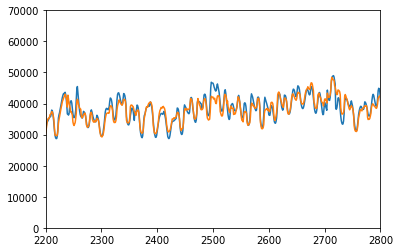

In [126]:
# Y_pred_ensemble = ensemble_search.best_estimator_.predict(X_ensemble_valid)
# Y_pred_ensemble = rf_ensemble.predict(X_ensemble_valid)
plt.plot(Y_ensemble_valid)
# plt.plot(X_ensemble_valid[:,4])
plt.plot(Y_pred_ensemble)
# plt.plot(X_ensemble_valid[:,3])
# r2_score(Y_ensemble_valid, X_ensemble_valid[:,4])
plt.xlim([2200,2800])
plt.ylim([0,70000])

### Use the true valid set for validation

In [706]:
df_train.loc[:, 'pred'] = train_pred.reshape(-1)

df_train.loc[:, 'residual'] = df_train.loc[:, 'usage_trend_removed'] - df_train.loc[:, 'pred']

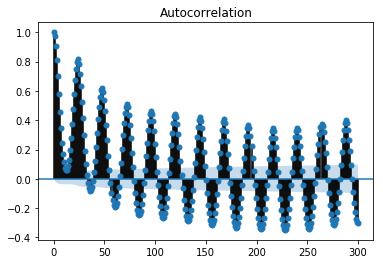

In [707]:
_ = plot_acf(df_train['residual'],lags=300)

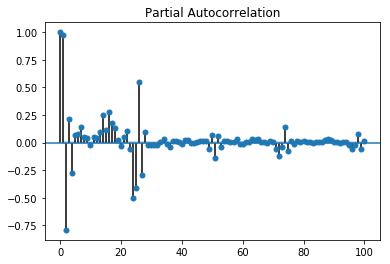

In [708]:
_ = plot_pacf(df_train['residual'],lags=100)

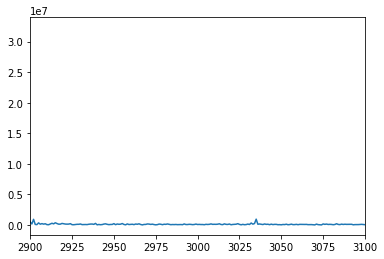

In [709]:
residual_fft = np.absolute(np.fft.fft(df_train['residual']))
plt.plot(residual_fft)
_ = plt.xlim([2900,3100])

In [270]:
len(df_train)

23175

In [275]:
23175/2/3.14*0.95

3505.7722929936303

In [274]:
np.arctan(1.4)

0.9505468408120751

In [277]:
23175/3030/24

0.3186881188118812

(-1, 70)

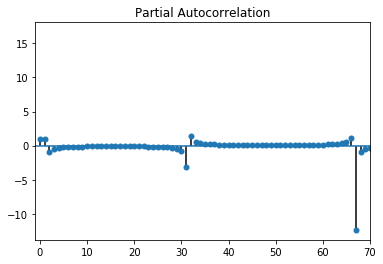

In [284]:
X = np.sin(np.arange(0,30,0.1))
_ = plot_pacf(X)
plt.xlim([-1,70])

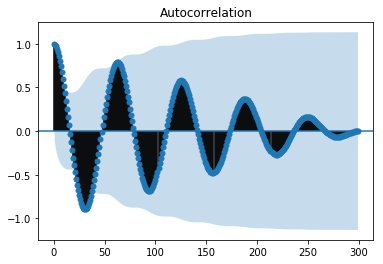

In [286]:
_ = plot_acf(X)

In [463]:
from statsmodels.tsa.stattools import ccf

In [486]:
ccf_1 = ccf(df_train['residual'], df_joined.iloc[:train_index]['T_Houston'])

(-0.2, 0.2)

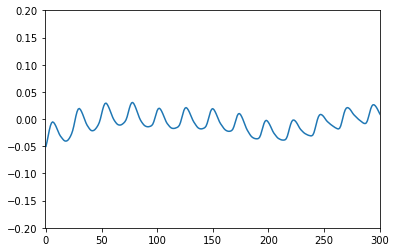

In [493]:
plt.plot(ccf_1)
plt.xlim([-1,300])
plt.ylim([-0.2,0.2])

In [482]:
5000/24

208.33333333333334

In [490]:
df_joined.head(1)

,datetime,usage,time,month,weekday,year,day,T_Houston,T_san_antonio,T_dallas
36934,2015-07-01 01:05:00,37456,1,7,2,2015,1,71.0,77.0,73.0


In [491]:
df_train.head(1)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,...,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,scaled_hours,scaled_hours_squared,scaled_hours_cubic,usage_trend_removed,residual,pred
0,2015-07-01 01:05:00,37456,1,7,2,2015,1,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1472.100301,-5889.020771,4416.92047


## Make prediction on the present data

In [139]:
# Load the electricity data from Sep 17 to Sep 24
elec_present = pd.read_csv('electricity_data/texas_sep_18.csv')

elec_present = elec_present.loc[:,['Timestamp (Hour Ending)', 'Demand (MWh)', 'Demand Forecast (MWh)']]
elec_present = elec_present.rename(columns={'Timestamp (Hour Ending)':'datetime','Demand (MWh)':'usage','Demand Forecast (MWh)':'prediction'})

elec_present['datetime'] = pd.to_datetime(elec_present['datetime'], format='%m/%d/%Y %I %p CDT')
elec_present['time'] = elec_present['datetime'].apply(lambda x:x.hour)
elec_present['month'] = elec_present['datetime'].apply(lambda x:x.month)
elec_present['weekday'] = elec_present['datetime'].apply(lambda x:x.weekday())
elec_present['year'] = elec_present['datetime'].apply(lambda x:x.year)
elec_present['day'] = elec_present['datetime'].apply(lambda x:x.day)

# Load the weather data
weather_sep_18 = pd.read_csv('electricity_data/weather_sep_18.csv')
# Round the date info
weather_sep_18['datetime'] = pd.to_datetime(weather_sep_18['DATE'], format='%Y-%m-%dT%H:%M:%S')
weather_sep_18['date'] = weather_sep_18['datetime'].apply(lambda date_time: round_time(date_time))
weather_sep_18['time'] = weather_sep_18['date'].apply(lambda x:x.hour)
weather_sep_18['month'] = weather_sep_18['date'].apply(lambda x:x.month)
weather_sep_18['day'] = weather_sep_18['date'].apply(lambda x:x.day)
# weather_sep_18['weekday'] = weather_sep_18['date'].apply(lambda x:x.weekday())
weather_sep_18['year'] = weather_sep_18['date'].apply(lambda x:x.year)
weather_sep_18['HourlyDryBulbTemperature'] = weather_sep_18['HourlyDryBulbTemperature'].apply(lambda s:parse_temperature(s))
weather_sep_18 = weather_sep_18.loc[weather_sep_18['HourlyDryBulbTemperature'].notna(),:]
weather_sep_18 = weather_sep_18[useful_columns]
weather_sep_18 = weather_sep_18[useful_columns].groupby(match_columns+['STATION'], as_index=False).mean()
houston = weather_sep_18.loc[weather_sep_18['STATION'] == 72243012960,:]
san_antonio = weather_sep_18.loc[weather_sep_18['STATION'] == 72259003927,:]
dallas = weather_sep_18.loc[weather_sep_18['STATION'] == 72253012921,:]
df_sep_18 = elec_present.merge(houston, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.merge(san_antonio, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.merge(dallas, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.drop(columns=['STATION_x', 'STATION_y', 'STATION']).rename(columns={'HourlyDryBulbTemperature_x':'T_Houston','HourlyDryBulbTemperature_y':'T_san_antonio','HourlyDryBulbTemperature':'T_dallas'})
df_sep_18 = df_sep_18.sort_values('datetime').reset_index(drop=True)

In [140]:
df_sep_18['hours'] = df_sep_18['datetime'].apply(lambda x: diff_in_hours(x))
# Yearly period.
df_sep_18['yearly_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 365.25*24, x))
df_sep_18['yearly_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 365.25*24, x))
df_sep_18['yearly_2_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 365.25*24/2, x)) # Starting from here are harmonics
df_sep_18['yearly_2_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 365.25*24/2, x))
df_sep_18['yearly_3_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 365.25*24/3, x))
df_sep_18['yearly_3_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 365.25*24/3, x))
# Weekly period.
df_sep_18['weekly_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 7*24, x))
df_sep_18['weekly_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 7*24, x))
df_sep_18['weekly_2_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 7*24/2, x))
df_sep_18['weekly_2_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 7*24/2, x))
# Dayly period.
df_sep_18['dayly_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 24, x))
df_sep_18['dayly_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 24, x))
df_sep_18['dayly_2_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 24/2, x))
df_sep_18['dayly_2_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 24/2, x))
df_sep_18['dayly_3_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 24/3, x))
df_sep_18['dayly_3_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 24/3, x))
df_sep_18['dayly_4_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 24/4, x))
df_sep_18['dayly_4_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 24/4, x))

In [141]:
df_sep_18 = df_sep_18.reset_index().rename({'Unnamed: 0': 'index'})
df_sep_18.head(1)

,index,datetime,usage,prediction,time,month,weekday,year,day,T_Houston,...,weekly_2_sin,weekly_2_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos
0,0,2019-09-16,47548,47905.0,0,9,0,2019,16,76.0,...,0.439491,-0.898247,-0.021815,0.999762,-0.043619,0.999048,-0.065403,0.997859,-0.087156,0.996195


In [142]:
features = ['time', 'weekday', 'month', 'T_Houston', 'T_san_antonio', 'T_dallas']

In [143]:
# Produce the x^2 and X^3 term for the ridge regressor

df_sep_18['scaled_hours'] = df_sep_18['hours']/100
df_sep_18['scaled_hours_squared'] = df_sep_18['scaled_hours']**2
df_sep_18['scaled_hours_cubic'] = df_sep_18['scaled_hours']**3

df_sep_18['usage_trend_removed'] = df_sep_18[['usage','scaled_hours']].apply(lambda row: remove_trend(row), axis=1)

samples_X = df_sep_18.loc[:, columns_x].values
train_pred = period_model.predict(samples_X)
df_sep_18['web_pred'] = df_sep_18['prediction']
df_sep_18['prediction'] = train_pred

df_sep_18['adjusted_pred'] = df_sep_18['prediction']* \
                            lr_coef.predict(df_sep_18[columns_x[:6]].values).reshape(-1) \
                            + lr_intercept.predict(df_sep_18[columns_x[:6]].values).reshape(-1)

df_sep_18['residual'] = df_sep_18['usage_trend_removed']-df_sep_18['adjusted_pred']

index = np.arange(48, len(df_sep_18))
X_sep_18 = df_sep_18[features[3:]].values
x, y = attenuate(df_sep_18[features].values, df_sep_18['usage'].values, 0.84, 3)
Y_pred_sep18 = my_estimator.predict(x, y)
# Y_pred_sep18 = LR_model.predict(RF_model.predict(x).reshape(-1,1))
X_sep18 = np.concatenate((index.reshape(-1,1), X_sep_18[48:,:], X_sep_18[24:-24,:], X_sep_18[48,:]-X_sep_18[24:-24,:], Y_pred_sep18[24:].reshape(-1,1)), axis=1)
df_X_sep18 = pd.DataFrame(X_sep18, columns=['index', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

df_residual = predict_residual(df_sep_18)
df_sep18_tspred = df_sep_18.merge(df_X_sep18, how='left', left_on='index', right_on='index')
df_sep18_tspred = df_sep18_tspred.merge(df_residual, how='inner', left_on='index', right_on='index')

In [144]:
df_sep18_tspred['ts_pred'] = df_sep18_tspred.apply(lambda row: add_trend(row), axis=1)
df_sep18_tspred['t2-t1'] = df_sep18_tspred['t_2'] - df_sep18_tspred['t_1']

X_ensemble_sep18 = df_sep18_tspred[ensemble_features].values
Y_ensemble_sep18 = df_sep18_tspred['usage'].values

# Y_sep18_pred = ensemble_search.best_estimator_.predict(X_ensemble_sep18)
Y_sep18_pred = rf_ensemble.predict(X_ensemble_sep18)

In [145]:
df_sep18_tspred.columns

Index(['index', 'datetime', 'usage', 'prediction', 'time', 'month', 'weekday',
       'year', 'day', 'T_Houston', 'T_san_antonio', 'T_dallas', 'hours',
       'yearly_sin', 'yearly_cos', 'yearly_2_sin', 'yearly_2_cos',
       'yearly_3_sin', 'yearly_3_cos', 'weekly_sin', 'weekly_cos',
       'weekly_2_sin', 'weekly_2_cos', 'dayly_sin', 'dayly_cos', 'dayly_2_sin',
       'dayly_2_cos', 'dayly_3_sin', 'dayly_3_cos', 'dayly_4_sin',
       'dayly_4_cos', 'scaled_hours', 'scaled_hours_squared',
       'scaled_hours_cubic', 'usage_trend_removed', 'web_pred',
       'adjusted_pred', 'residual', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', 'residual_pred', 't_2', 't_1', 'ts_pred', 't2-t1'],
      dtype='object')

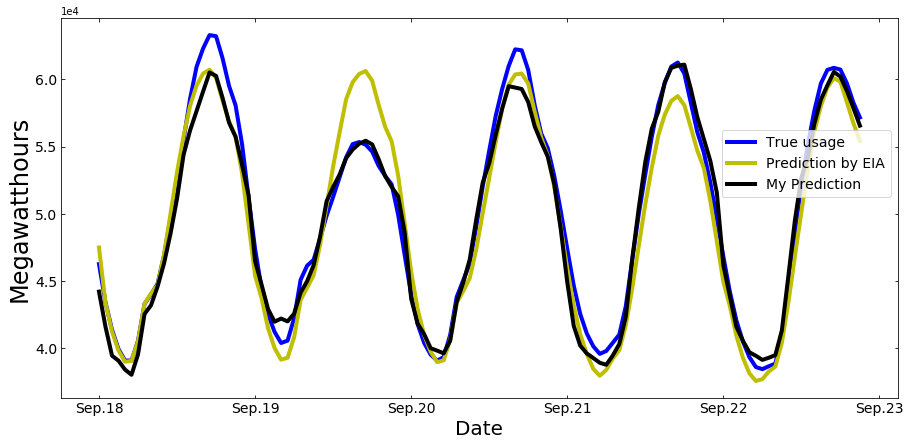

In [162]:
fig,ax = plt.subplots(figsize=(15,7))
plt.plot(Y_ensemble_sep18, 'b', linewidth=4)
plt.plot(df_sep18_tspred['web_pred'], 'y', linewidth=4)
plt.plot(Y_sep18_pred, 'black', linewidth=4)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Megawatthours', fontsize=24)
plt.legend(['True usage', 'Prediction by EIA', 'My Prediction'], fontsize=14, bbox_to_anchor=(0.5, 0.51, 0.5, 0.5))
ax.xaxis.set_major_locator(MultipleLocator(24))
ax.set_xticklabels(['', 'Sep.18', 'Sep.19', 'Sep.20', 'Sep.21', 'Sep.22', 'Sep.23'])
# Adjust the display style
plt.tick_params(which = 'both',top=True,right=True,direction='in')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [722]:
'''
# Save the ensemble model
with open('models/rf_ensemble', 'wb') as file:
    pickle.dump(ensemble_search.best_estimator_, file)
'''